# Flavor Transformation Tests

Load a supernova model and plot the effects of flavor transformations on the neutrino spectra at a particular time.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u 

from snewpy.neutrino import Flavor, MassHierarchy
from snewpy.models import Nakazato_2013
from snewpy.flavor_transformation import NoTransformation, \
                                         AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence

In [2]:
mpl.rc('font', size=16)

### Model: Nakazato 2013

Load a Nakazato model.

In [3]:
ifile = '../../models/Nakazato_2013/nakazato-shen-z0.004-t_rev100ms-s20.0.fits'
model = Nakazato_2013(ifile)

In [4]:
model

**Nakazato_2013 Model**: nakazato-shen-z0.004-t_rev100ms-s20.0.fits

|Parameter|Value|
|:---------|:-----:|
|Progenitor mass | $20$ $\mathrm{M_{\odot}}$|
|Metallicity | $0.004$|
|Revival time | $100$ $\mathrm{ms}$|
|EOS | SHEN|

In [5]:
model.meanE

{<Flavor.NU_E: 2>: <Quantity [ 5.14576927,  5.29909703,  5.47592716,  5.67405747,  5.89125924,
             6.12333092,  6.36741838,  6.62506534,  6.90060112,  7.19879042,
             7.52404046,  7.59180764,  7.65996032,  7.72821732,  7.7961807 ,
             7.86343071,  7.92954253,  7.9939721 ,  8.05613277,  8.11544849,
             8.17124512,  8.22315363,  8.27125927,  8.31648962,  8.36127261,
             8.41063057,  8.47325403,  8.56192874,  8.69113926,  8.87262697,
             9.11017562,  9.39542339,  9.70993541, 10.03177419, 10.3411    ,
            10.62459466, 10.87570043, 11.09303825, 11.27841343, 11.435309  ,
            11.56741276, 11.67848588, 11.77197254, 11.85053447, 11.91661455,
            11.97209631, 12.01836963, 12.05653261, 12.08723967, 12.11123062,
            12.12902954, 12.14108292, 12.14779911, 12.1494284 , 12.14615219,
            12.13789062, 12.12445157, 12.10555793, 12.08096925, 12.05072099,
            12.01479853, 11.99488907, 11.97372789, 11.9514

## Flavor Transformations

Apply a set of flavor transformations at an early time in the explosion.

In [6]:
def plot_spec(model, flav_xform, t=50*u.ms, E=np.linspace(0,100,201)*u.MeV, check_imo=False):
    """Plot initial and oscillated neutrino spectra.
    
    Parameters
    ----------
    model : SupernovaModel
        An input model from a CCSN simulation.
    flav_xform : FlavorTransformation
        A FlavorTransformation subclass; used to create an instance.
    t : astropy.Quantity
        Time to compute the spectrum.
    E : ndarray
        List of energies to compute the spectrum.
    check_imo : bool
        Check the effect of inverting the neutrino mass hierarchy.
    """
    if check_imo:
        xform_nmo = flav_xform(mh=MassHierarchy.NORMAL)
        xform_imo = flav_xform(mh=MassHierarchy.INVERTED)
    else:
        xform_nmo = flav_xform()
        xform_imo = xform_nmo
        
    # Compute the initial and oscillated spectra.
    ispec = model.get_initialspectra(t, E)
    ospec_nmo = model.get_oscillatedspectra(t, E, xform_nmo)
    ospec_imo = model.get_oscillatedspectra(t, E, xform_imo)

    # Plot the spectra.
    fig, axes = plt.subplots(1,3, figsize=(18,5), sharex=True, sharey=True, tight_layout=True)

    mh = ['NMO', 'IMO']

    for i, spec in enumerate([ispec, ospec_nmo, ospec_imo]):
        ax = axes[i]
        for flavor in Flavor:
            ax.plot(E, spec[flavor],
                    label=flavor.to_tex(),
                    color='C0' if flavor.is_electron else 'C1',
                    ls='-' if flavor.is_neutrino else ':', lw=2,
                    alpha=0.7)

        ax.set(xlabel=r'$E$ [{}]'.format(E.unit),
               title='Initial Spectra: $t = ${:.1f}'.format(t) if i==0 else 'Oscillated Spectra: {}'.format(mh[i-1]))
        ax.grid()
        ax.legend(loc='upper right', ncol=2, fontsize=16)

    ax = axes[0]
    ax.set(ylabel=r'flux [erg$^{-1}$ s$^{-1}$]')

    fig.tight_layout()
    return fig

### `NoTransformation`

In [7]:
np.__file__, np.__version__

('/Users/sybenzvi/anaconda3/envs/icecube/lib/python3.7/site-packages/numpy/__init__.py',
 '1.19.2')

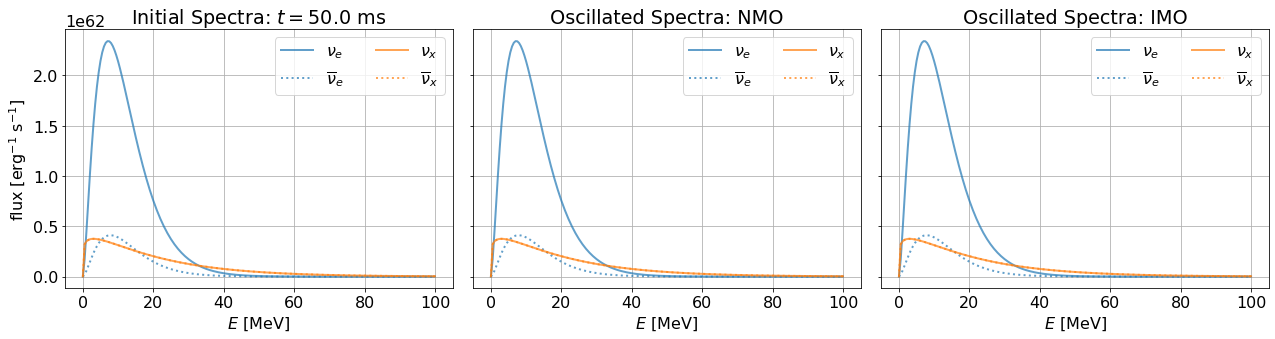

In [8]:
fig = plot_spec(model, NoTransformation)

### `AdiabaticMSW`

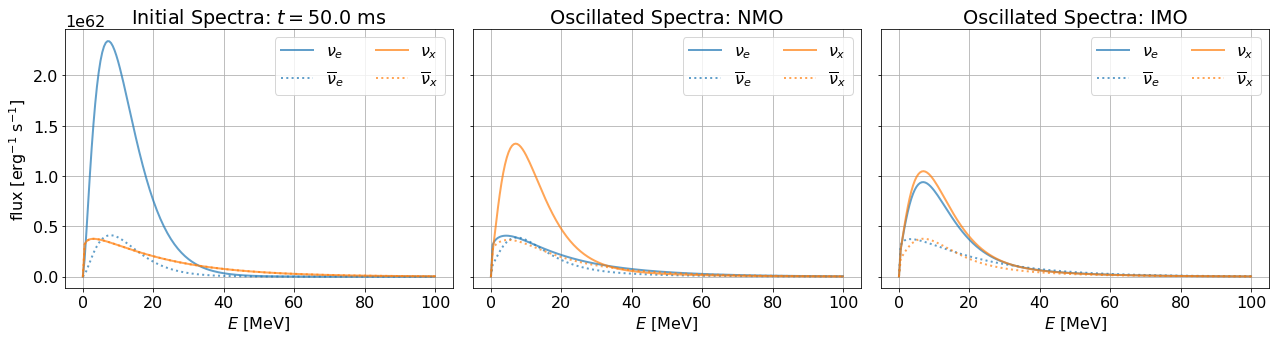

In [9]:
fig = plot_spec(model, AdiabaticMSW, check_imo=True)

### `NonAdiabaticMSWH`

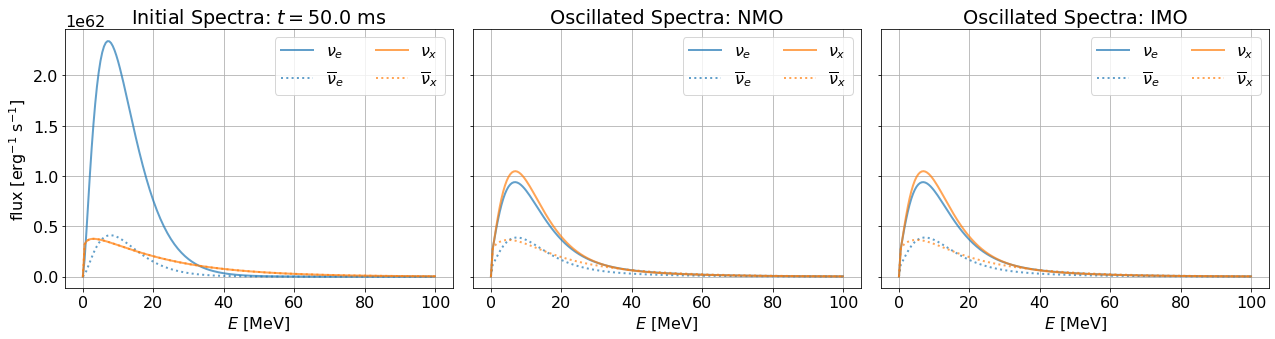

In [10]:
fig = plot_spec(model, NonAdiabaticMSWH)

### `TwoFlavorDecoherence`

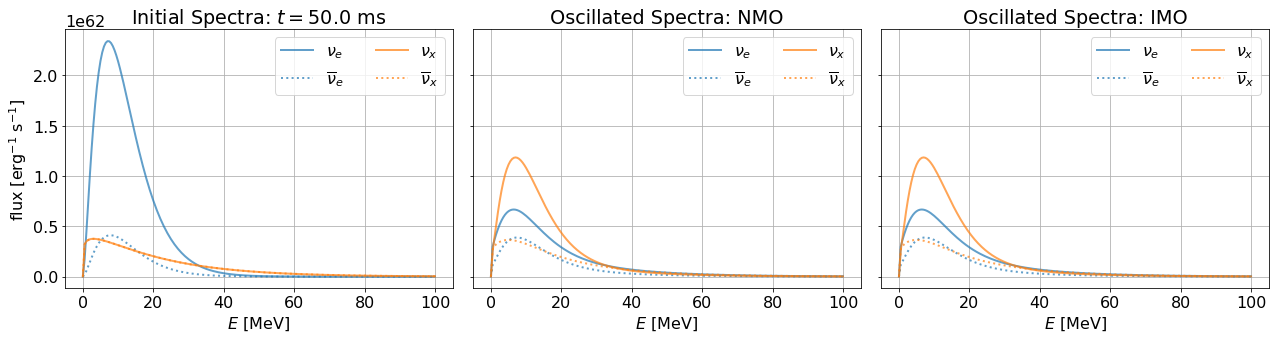

In [11]:
fig = plot_spec(model, TwoFlavorDecoherence)

### `ThreeFlavorDecoherence`

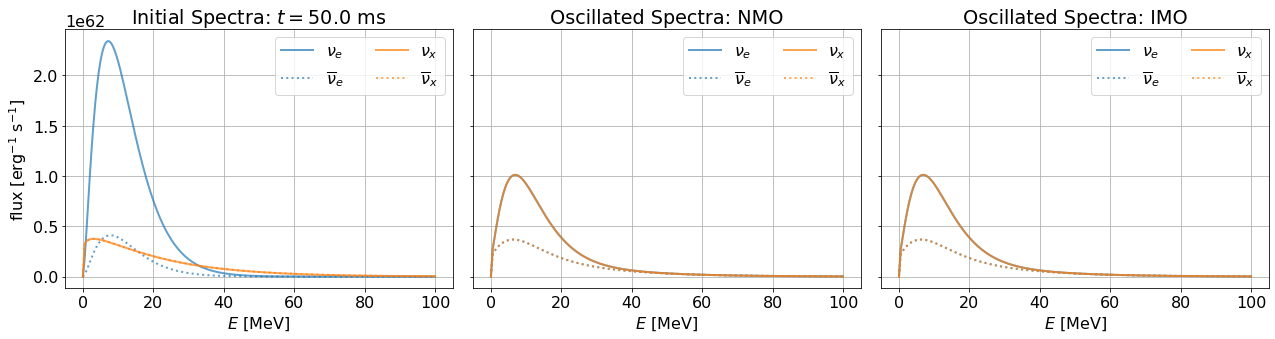

In [12]:
fig = plot_spec(model, ThreeFlavorDecoherence)